In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

I have the $U$, $\Sigma$, and $V$ matrices, now I want to do something with it

- $U$ - documents
- $\Sigma$ - interaction between documents and words
- $V$ - words

Want to look at: give a document, what is the closest document.

(But first we will restart the whole process to ensure ids match)

### Getting factorized matrices from Day 53

- Let say use 100 components

In [3]:
import numpy as np
from scipy.sparse import csr_matrix

def save_sparse_csr(filename, array):
    # note that .npz extension is added automatically
    np.savez(filename, data=array.data, indices=array.indices,
             indptr=array.indptr, shape=array.shape)

def load_sparse_csr(filename):
    # here we need to add .npz extension manually
    loader = np.load(filename + '.npz')
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                      shape=loader['shape'])

In [4]:
wc_file = "../../data/documents/word_counts.txt"
X = load_sparse_csr(wc_file)

In [5]:
from sklearn.utils.extmath import randomized_svd

U, s, Vh = randomized_svd(X, n_components=100, n_iter=5, random_state=5)

In [6]:
U.shape, s.shape, Vh.shape

((177140, 100), (100,), (100, 99946))

### Compute distances

In text analysis, people generally use Euclidean or Cosine distances.

In [7]:
from sklearn.metrics import pairwise_distances

# dist = pairwise_distances(U, U, metric='euclidean')
# dist = pairwise_distances(U, U, metric='cosine')

With regards to finding the closest document, will use matrix $U$.

Trying to compute the pairwise of all pairs -- crashed my laptop. Better not try that again. As a work around, we are able to for a given document, calculate this distance with every other document.

1 to many (yes) vs many to many (no).

In [8]:
# Look at first document
dist = pairwise_distances(np.asmatrix(U[0]), U, metric='euclidean')
dist

array([[  6.58544508e-10,   2.91702575e-02,   4.66361619e-02, ...,
          2.20488609e-02,   3.71456636e-02,   3.08945979e-02]])

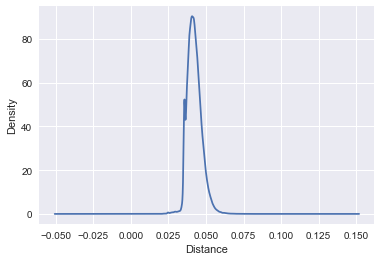

In [9]:
# Distribution of distances
df_dist = pd.DataFrame(np.transpose(dist), columns=["dist"])

pd.DataFrame(df_dist).plot.kde(legend=False)
plt.xlabel("Distance")

In [10]:
# Sort by distance
top_5 = df_dist.sort_values("dist").head()
top_5

,dist
0,6.585445e-10
131582,1.690946e-02
131258,1.705223e-02
129792,1.722522e-02
159369,1.842629e-02


Closest document always going to be self. Sanity check passed.

### Identify documents

Data was previously saved in "doc_proc2.txt" where column 1 is id and column 2 is text

In [11]:
df = pd.read_csv("../../data/documents/doc_proc2.txt", sep="\t", names=["id", "document"])
df_original = pd.read_csv("../../data/documents/doc.txt", sep="\t", names=["id", "document"])

In [12]:
df.iloc[top_5.index]

,id,document
0,1312331512,fulli develop anim seri requir profession anim...
131582,1939908068,hamstrong anim seri hamster mission escap anim...
131258,542664697,never watch anim challeng watch seri anim non ...
129792,74332521,detroit farm anim seri farm anim daili struggl...
159369,1672120020,hope kickstart anim career new anim seri


In [13]:
for index, row in df.iloc[top_5.index].iterrows():
    original_text = df_original[df_original['id'] == row['id']].iloc[0]['document']
    
    print('>> %s | %s' % (row['id'], row['document']),
          original_text, "\n", sep="\n")
    

>> 1312331512 | fulli develop anim seri requir profession anim first homeanim ep onlin
We have a fully developed 2D animated series that requires more professional animation. Our first 2 home-animated eps are up online.


>> 1939908068 | hamstrong anim seri hamster mission escap anim test laboratori
Hamstrong is an animated series about a hamster on a mission to escape an animal testing laboratory.


>> 542664697 | never watch anim challeng watch seri anim non stop intend document crazi happen
I have never watched anime and I have been challenged to watch 10 series of anime non stop. I intend to document the crazy that happens


>> 74332521 | detroit farm anim seri farm anim daili struggl grow urban area detroit mi
Detroit Farm is an animated series about farm animals and their daily struggles of growing up in an urban area such as Detroit, MI.


>> 1672120020 | hope kickstart anim career new anim seri
This is to (hopefully) 'kickstart' my animation career and a new animated series.




Looking good -- they are all about anime